**Model de donnée  pour la detection du genre .
L'objectif de ce projet est de :

📂 Importation des bibliothèques nécessaires pour le projet



In [1]:
# Cellule a executer pour importer toutes les biblioteques necessaire pour le projet .
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input , BatchNormalization
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import zipfile
from tqdm import tqdm
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import AveragePooling2D, AveragePooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D

Connexion au drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Chemin vers le fichier ZIP
zip_path = '/content/drive/MyDrive/Sae_BUT3_IA/archive.zip'
extracted_path = '/content/extracted'

## Extraction des Datas




In [ ]:


# Extraire le contenu du fichier ZIP
if not os.path.exists(extracted_path):
    print("Extraction des fichiers...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print("Extraction terminée !")

Extraction des fichiers...
Extraction terminée !


Extraction du genre


In [ ]:
#extraction de l'age et du genre a l'aide du nom du fichier .

# Mettre à jour data_dir avec le dossier extrait
data_dir = extracted_path +"/UTKFace"

image_filenames = os.listdir(data_dir)
age_labels = []
gender_labels = []
image_paths = []
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  # Skip directories or files not ending with '.jpg'
  if os.path.isdir(os.path.join(data_dir, image)) or not image.lower().endswith(('.jpg', '.jpeg', '.png')):
    continue

  image_path = os.path.join(data_dir, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)



100%|██████████| 23708/23708 [00:00<00:00, 133598.13it/s]


Chargement et prétraitement des images




In [ ]:
images, labels = [], []

print("Chargement des images...")
for file in tqdm(os.listdir(data_dir), desc="Images traitées", unit="fichier"):
    if file.endswith(".jpg"):
        try:
            # Extraction des informations depuis le nom de fichier
            parts = file.split("_")
            gender = int(parts[1])  # 0 ou 1 pour le genre
            img_path = os.path.join(data_dir, file)
            img = load_img(img_path, target_size=(96, 96), color_mode="grayscale")  # Redimensionnement et utilisation de grayscale
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(gender)
        except Exception as e:
            print(f"Erreur avec le fichier {file}: {e}")

print(f"Chargement terminé : {len(images)} images et {len(labels)} labels.")


#a executer quand la normalisation bug


Chargement des images...


Images traitées: 100%|██████████| 23708/23708 [00:14<00:00, 1607.09fichier/s]

Chargement terminé : 23708 images et 23708 labels.


✅ Vérification de la cohérence des données pour eviter de la perte de données

In [ ]:
  print(len(age_labels))
  print(len(gender_labels))
  print(len(images))

  if len(age_labels) == len(gender_labels) == len(images):
    print("Les listes ont bien la même longueur.")
  else:
    print("Les listes ont des longueurs différentes.")



23708
23708
23708
Les listes ont bien la même longueur.


📊 Création d'un DataFrame pour organiser les données

In [ ]:

df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)


,image_path,age,gender
0,/content/extracted/UTKFace/30_0_0_201701201342...,30,0
1,/content/extracted/UTKFace/24_0_0_201701171452...,24,0
2,/content/extracted/UTKFace/12_0_3_201701042257...,12,0
3,/content/extracted/UTKFace/24_0_3_201701042301...,24,0
4,/content/extracted/UTKFace/37_0_3_201701191932...,37,0


📈 Analyse de la répartition des genres dans les données


In [ ]:

# Calculate the counts of men and women
gender_counts = df['gender'].value_counts()

# Print the counts
print(f"Number of women: {gender_counts.get(1, 0)}")  # Using .get() to handle missing values
print(f"Number of men: {gender_counts.get(0, 0)}")   # Using .get() to handle missing values


Number of women: 11317
Number of men: 12391


# Representation graphique de la repartition d'hommes et de femmes

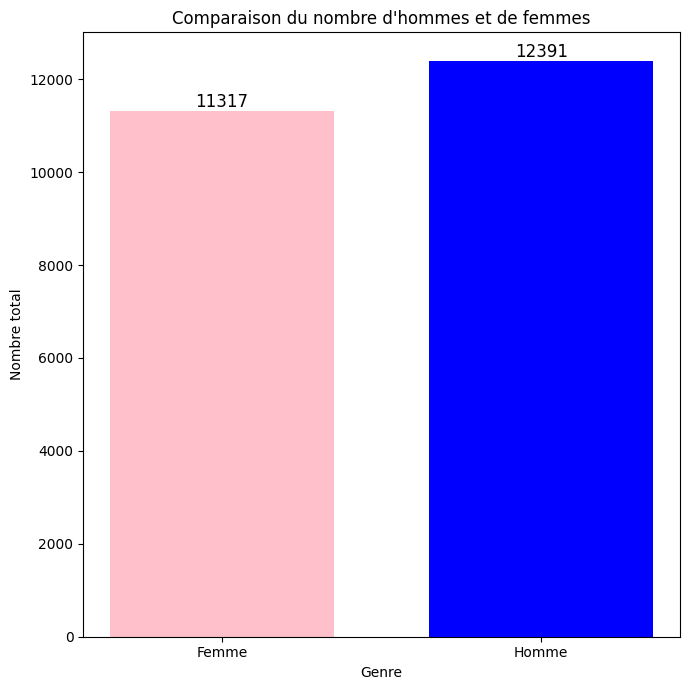

In [ ]:

# Prepare labels and data
labels = ['Femme', 'Homme']
counts = [gender_counts.get(1, 0), gender_counts.get(0, 0)]


plt.figure(figsize=(7, 7))
bars = plt.bar(labels, counts, color=['pink', 'blue'], width=0.7)

# Ajouter le texte au-dessus des barres
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom', fontsize=12)

plt.title('Comparaison du nombre d\'hommes et de femmes')
plt.ylabel('Nombre total')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()



Normalisation des images et séparation des données en ensembles d'entraînement et de validation



In [ ]:

#normalisation des images
images = np.array(images) / 255.0
# Store the original labels in a different variable
image_labels = np.array(labels)

#séparation des données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(images, image_labels, test_size=0.2, random_state=42)

#si cette cellule ne fonctionne pas  executer la cellule numero 4 et re executer celle ci


 Création du modèle de réseau de neurones convolutifs (CNN) avec régularisation et Dropout pour eviter le surapprentissage et également earlyStopping pour surveiller l'entrainement

In [ ]:
#création du model


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Ajout du L2
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

#earlystopping

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Vérification de la forme des ensembles de données

In [ ]:

print("Shape des images X_train :", X_train.shape)  # Doit être (n,img size ,img size ,1)
print("Shape des labels âge :", y_train.shape)  # Doit être (n,)
print("Shape des labels genre :", y_train.shape)  # Doit être (n,)


Shape des images X_train : (18966, 96, 96, 1)
Shape des labels âge : (18966,)
Shape des labels genre : (18966,)


Compilation du modèle avec l'optimiseur Adam et ajustement du taux d'apprentissage  .  Adam est parametré avec un taux d'apprentissage faible pour limiter le surapprentissage

In [ ]:
#compilation du model

model.compile(optimizer=Adam(learning_rate=0.0001), # ajout du learning rate pour reduire le surapprentisage
              loss='binary_crossentropy',
              metrics=['accuracy'])


Implémentation d'EarlyStopping et réduction du learning rate pour éviter le surapprentissage

In [ ]:
#utilisation de earlystopping pour eviter le surapprentissage
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau

# Configuration d'EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.01,  # Nécessite une augmentation d'au moins 0.01 pour arrêter
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Réduction du learning rate de 50%
    patience=7,  # Réduit le learning rate si pas d'amélioration après 7 epochs
    min_lr=1e-4
)

Configuration du ModelCheckpoint pour sauvegarder le meilleur modèle basé sur la précision de validation

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

Entraînement du modèle avec callbacks et gestion des images pour la prédiction
Les callbacks utilisés sont :
1.   Early_stopping
2.   reduce_lr
3.   checkpoint

Utilisation d'un nombre d'epoch peu élévé pour eviter de crasher en utilisant toute la memoire de Google colab mais suffisant pour rendre le model performant .





In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_train,y_train),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping,reduce_lr,checkpoint] ) # Ajout du callback

image_filenames = os.listdir(data_dir)
age_labels = []
gender_labels = []
image_paths = []
random.shuffle(image_filenames)


for image in tqdm(image_filenames):
  # On skip les directories ou lien qui ne finissent pas par '.jpg'
  if os.path.isdir(os.path.join(zip_path, image)) or not image.lower().endswith(('.jpg', '.jpeg', '.png')) :
    image_paths.append(image_path)

Epoch 1/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7524 - loss: 4.6086
Epoch 1: val_accuracy improved from -inf to 0.86882, saving model to best_model.h5


593/593 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.7525 - loss: 4.6074 - val_accuracy: 0.8688 - val_loss: 2.7142 - learning_rate: 1.0000e-04
Epoch 2/50
592/593 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8663 - loss: 2.3784
Epoch 2: val_accuracy improved from 0.86882 to 0.88226, saving model to best_model.h5


593/593 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.8663 - loss: 2.3774 - val_accuracy: 0.8823 - val_loss: 1.5712 - learning_rate: 1.0000e-04
Epoch 3/50
591/593 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8914 - loss: 1.3906
Epoch 3: val_accuracy improved from 0.88226 to 0.92450, saving model to best_model.h5


593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8914 - loss: 1.3899 - val_accuracy: 0.9245 - val_loss: 0.9263 - learning_rate: 1.0000e-04
Epoch 4/50
590/593 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9079 - loss: 0.8702
Epoch 4: val_accuracy improved from 0.92450 to 0.93826, saving model to best_model.h5


593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9079 - loss: 0.8696 - val_accuracy: 0.9383 - val_loss: 0.6031 - learning_rate: 1.0000e-04
Epoch 5/50
592/593 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9246 - loss: 0.5765
Epoch 5: val_accuracy improved from 0.93826 to 0.95096, saving model to best_model.h5


593/593 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9246 - loss: 0.5763 - val_accuracy: 0.9510 - val_loss: 0.4124 - learning_rate: 1.0000e-04
Epoch 6/50
591/593 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9420 - loss: 0.4054
Epoch 6: val_accuracy improved from 0.95096 to 0.95513, saving model to best_model.h5


593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9420 - loss: 0.4053 - val_accuracy: 0.9551 - val_loss: 0.3183 - learning_rate: 1.0000e-04
Epoch 7/50
590/593 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9566 - loss: 0.2989
Epoch 7: val_accuracy improved from 0.95513 to 0.97237, saving model to best_model.h5


593/593 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9566 - loss: 0.2988 - val_accuracy: 0.9724 - val_loss: 0.2274 - learning_rate: 1.0000e-04
Epoch 8/50
590/593 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9633 - loss: 0.2271
Epoch 8: val_accuracy improved from 0.97237 to 0.97406, saving model to best_model.h5


593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9633 - loss: 0.2271 - val_accuracy: 0.9741 - val_loss: 0.1929 - learning_rate: 1.0000e-04
Epoch 9/50
590/593 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9683 - loss: 0.1898
Epoch 9: val_accuracy improved from 0.97406 to 0.98344, saving model to best_model.h5


593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9683 - loss: 0.1898 - val_accuracy: 0.9834 - val_loss: 0.1514 - learning_rate: 1.0000e-04
Epoch 10/50
590/593 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9780 - loss: 0.1470
Epoch 10: val_accuracy did not improve from 0.98344
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9780 - loss: 0.1471 - val_accuracy: 0.9834 - val_loss: 0.1282 - learning_rate: 1.0000e-04
Epoch 11/50
589/593 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9810 - loss: 0.1287
Epoch 11: val_accuracy improved from 0.98344 to 0.98703, saving model to best_model.h5


593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9810 - loss: 0.1287 - val_accuracy: 0.9870 - val_loss: 0.1080 - learning_rate: 1.0000e-04
Epoch 12/50
592/593 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9867 - loss: 0.1068
Epoch 12: val_accuracy did not improve from 0.98703
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9867 - loss: 0.1068 - val_accuracy: 0.9741 - val_loss: 0.1223 - learning_rate: 1.0000e-04
Epoch 13/50
589/593 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9891 - loss: 0.0892
Epoch 13: val_accuracy did not improve from 0.98703
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9890 - loss: 0.0893 - val_accuracy: 0.9862 - val_loss: 0.0894 - learning_rate: 1.0000e-04
Epoch 14/50
590/593 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9853 - loss: 0.0926
Epoch 14: val_accuracy improved from 0.98703 to 0.99251, saving model to best_model.h5


593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9853 - loss: 0.0926 - val_accuracy: 0.9925 - val_loss: 0.0725 - learning_rate: 1.0000e-04
Epoch 15/50
589/593 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9873 - loss: 0.0841
Epoch 15: val_accuracy improved from 0.99251 to 0.99409, saving model to best_model.h5


593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9873 - loss: 0.0840 - val_accuracy: 0.9941 - val_loss: 0.0643 - learning_rate: 1.0000e-04
Epoch 16/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9916 - loss: 0.0681
Epoch 16: val_accuracy did not improve from 0.99409
593/593 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9916 - loss: 0.0681 - val_accuracy: 0.9935 - val_loss: 0.0646 - learning_rate: 1.0000e-04
Epoch 17/50
591/593 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9901 - loss: 0.0703
Epoch 17: val_accuracy did not improve from 0.99409
593/593 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9901 - loss: 0.0703 - val_accuracy: 0.9865 - val_loss: 0.0794 - learning_rate: 1.0000e-04
Epoch 18/50
591/593 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9915 - loss: 0.0652
Epoch 18: val_accuracy did not improve from 0.99409
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9915 - loss: 0.0652 - val_accuracy: 0.9927 - val_loss: 0.0588 - learning_rate: 1.000

593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9936 - loss: 0.0490 - val_accuracy: 0.9964 - val_loss: 0.0384 - learning_rate: 1.0000e-04
Epoch 26/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9968 - loss: 0.0370
Epoch 26: val_accuracy did not improve from 0.99636
593/593 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9967 - loss: 0.0370 - val_accuracy: 0.9930 - val_loss: 0.0473 - learning_rate: 1.0000e-04
Epoch 27/50
589/593 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9953 - loss: 0.0414
Epoch 27: val_accuracy did not improve from 0.99636
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9953 - loss: 0.0415 - val_accuracy: 0.9936 - val_loss: 0.0506 - learning_rate: 1.0000e-04
Epoch 28/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9901 - loss: 0.0580
Epoch 28: val_accuracy did not improve from 0.99636
593/593 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9901 - loss: 0.0580 - val_accuracy: 0.9846 - val_loss: 0.0721 - learning_rate: 1.000

593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9960 - loss: 0.0429 - val_accuracy: 0.9965 - val_loss: 0.0384 - learning_rate: 1.0000e-04
Epoch 31/50
591/593 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9959 - loss: 0.0385
Epoch 31: val_accuracy did not improve from 0.99652
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9959 - loss: 0.0385 - val_accuracy: 0.9927 - val_loss: 0.0447 - learning_rate: 1.0000e-04
Epoch 32/50
592/593 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9954 - loss: 0.0400
Epoch 32: val_accuracy did not improve from 0.99652
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9954 - loss: 0.0400 - val_accuracy: 0.9921 - val_loss: 0.0483 - learning_rate: 1.0000e-04
Epoch 33/50
590/593 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9936 - loss: 0.0458
Epoch 33: val_accuracy did not improve from 0.99652
593/593 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9936 - loss: 0.0458 - val_accuracy: 0.9950 - val_loss: 0.0441 - learning_rate: 1.00

593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9925 - loss: 0.0487 - val_accuracy: 0.9973 - val_loss: 0.0359 - learning_rate: 1.0000e-04
Epoch 35/50
591/593 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9973 - loss: 0.0352
Epoch 35: val_accuracy improved from 0.99726 to 0.99789, saving model to best_model.h5


593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9973 - loss: 0.0352 - val_accuracy: 0.9979 - val_loss: 0.0273 - learning_rate: 1.0000e-04
Epoch 36/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9979 - loss: 0.0265
Epoch 36: val_accuracy improved from 0.99789 to 0.99842, saving model to best_model.h5


593/593 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9979 - loss: 0.0265 - val_accuracy: 0.9984 - val_loss: 0.0222 - learning_rate: 1.0000e-04
Epoch 37/50
592/593 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9972 - loss: 0.0236
Epoch 37: val_accuracy did not improve from 0.99842
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9972 - loss: 0.0236 - val_accuracy: 0.9970 - val_loss: 0.0243 - learning_rate: 1.0000e-04
Epoch 38/50
592/593 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9939 - loss: 0.0360
Epoch 38: val_accuracy did not improve from 0.99842
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9939 - loss: 0.0360 - val_accuracy: 0.9873 - val_loss: 0.0702 - learning_rate: 1.0000e-04
Epoch 39/50
592/593 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9888 - loss: 0.0641
Epoch 39: val_accuracy did not improve from 0.99842
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9888 - loss: 0.0641 - val_accuracy: 0.9950 - val_loss: 0.0479 - learning_rate: 1.00

100%|██████████| 23708/23708 [00:01<00:00, 18093.31it/s]


In [ ]:
model.evaluate(X_val, y_val)

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8930 - loss: 0.4564


[0.4343450665473938, 0.8958245515823364]


 Sauvegarde du modèle entraîné au format Keras

In [ ]:
# model genre =
model.save("my_modelGenre.keras")  # Sauvegarde du model de genre en format natif Keras
#model age = "best_age_model.h5"
#model age et genre = "best_age_genre_model.h5"

In [ ]:
import os
print(os.getcwd())  # Affiche le répertoire actuel
print(os.listdir())  # Liste les fichiers présents dans le répertoire


/content
['.config', 'drive', 'sample_data']


Chargement du modèle sauvegardé pour éviter une nouvelle exécution de model.fit

In [ ]:
#model = keras.models.load_model("my_model.keras")  # Rechargement du model


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 Évaluation du modèle sur l'ensemble de validation et visualisation des courbes de perte et précision
 Un val_accuracy de [0.90-0.95] est une bonne valeur pour avoir un model  performant

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8930 - loss: 0.4564
Validation Loss: 0.4343450665473938
Validation Accuracy: 0.8958245515823364


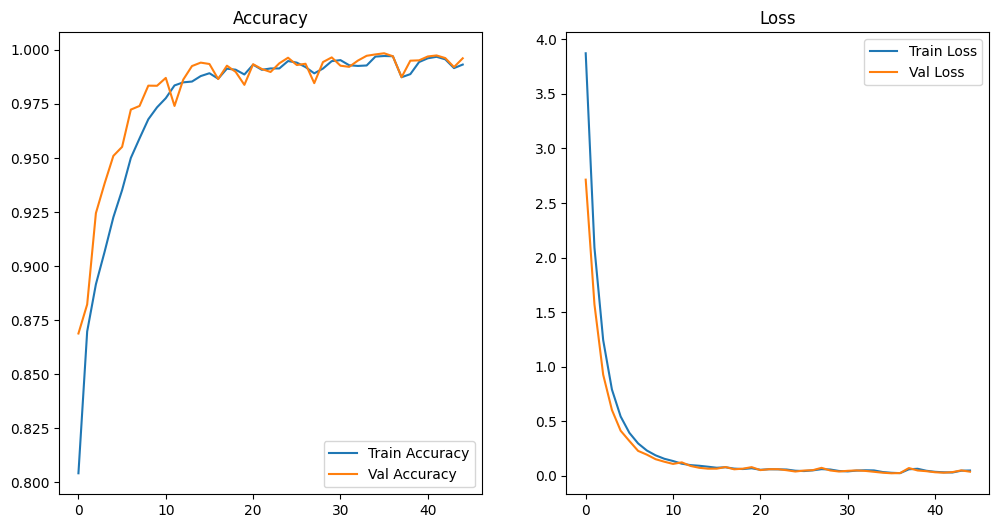

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Visualisation des courbes de perte et de précision
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [ ]:
#model = load_model("best_model.h5")

Test du model pour prédir le genre avec une image specifique (lien de l'image est necessaire )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


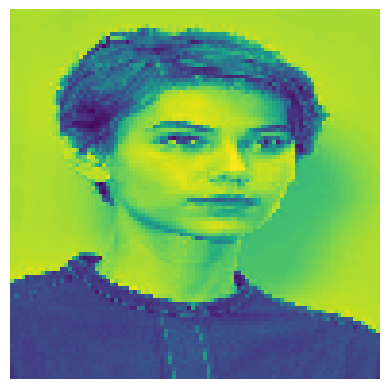

La personne est une femme (prédiction : 0.99)


In [ ]:
def predict_gender(image_path):
    # Charger l'image
    img = load_img(image_path, target_size=(96, 96), color_mode='grayscale')  # Chargement en couleur
    img_array = img_to_array(img)  # Conversion en tableau numpy
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour batch_size
    img_array = img_array / 255.0  # Normaliser les pixels (facultatif si ton modèle a été normalisé pendant l'entraînement)

    # Prédire le genre
    prediction = model.predict(img_array)

    # Affichage de l'image
    plt.imshow(img)
    plt.axis('off')  # Masquer les axes
    plt.show()

    # Afficher la prédiction
    # Access the probability value using prediction[0][0]
    if prediction[0][0] > 0.5:
        print("La personne est une femme (prédiction : {:.2f})".format(prediction[0][0]))
    else:
        print("La personne est un homme (prédiction : {:.2f})".format(prediction[0][0]))

# Utilisation de la fonction avec l'image spécifique
image_path = '/content/drive/MyDrive/Sae_BUT3_IA/extracted/image2.jpg'  # Remplace par le chemin de l'image que tu veux tester
predict_gender(image_path)

 Prédiction aléatoire du genre à partir d'une image choisie au hasard dans le dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Chemin de l'image : /content/extracted/UTKFace/45_0_3_20170119194628649.jpg.chip.jpg
Prédiction : Homme (Proba: 0.000)


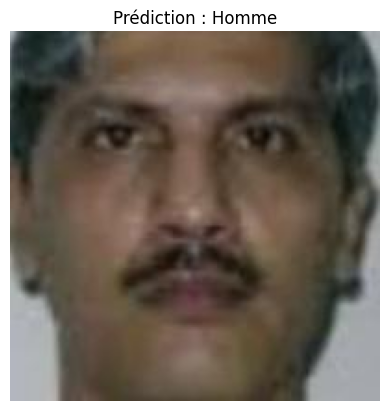

In [ ]:
# Choisir aléatoirement un fichier dans data_dir
random_filename = random.choice(os.listdir(data_dir))
random_image_path = os.path.join(data_dir, random_filename)

# Charger et prétraiter l'image
img = load_img(random_image_path, target_size=(96, 96),color_mode="grayscale")  # Cohérent avec le modèle
img_array = img_to_array(img)          # shape = (96,96, 3)
img_array = img_array / 255.0          # Normalisation
img_array = np.expand_dims(img_array, 0)  # shape = (1, 64, 64, 3)

# Prédiction
prediction = model.predict(img_array)
predicted_class = 1 if prediction > 0.5 else 0

# Affichage
class_names = ['Homme', 'Femme']  # 0 = Homme, 1 = Femme
print(f"Chemin de l'image : {random_image_path}")
print(f"Prédiction : {class_names[predicted_class]} (Proba: {prediction[0][0]:.3f})")

plt.imshow(load_img(random_image_path))  # Afficher l'image brute
plt.title(f"Prédiction : {class_names[predicted_class]}")
plt.axis('off')
plt.show()


Meme chose que la cellule du dessus , mais en generant non pas 1 image mais 10 images aléatoire du datasets

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image '12_1_0_20170109203709140.jpg.chip.jpg': prédiction = Femme (Proba: 1.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Image '72_0_1_20170113184626575.jpg.chip.jpg': prédiction = Homme (Proba: 0.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image '51_0_0_20170117173658531.jpg.chip.jpg': prédiction = Homme (Proba: 0.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image '53_1_0_20170110123801468.jpg.chip.jpg': prédiction = Femme (Proba: 1.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image '2_1_4_20161221201536537.jpg.chip.jpg': prédiction = Femme (Proba: 0.998)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image '61_0_0_20170109015526938.jpg.chip.jpg': prédiction = Homme (Proba: 0.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image '78_0_1_20170111222209093.jpg.chip.jpg': prédiction = Homme (Proba: 0.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image '29_0_1_20170116202000095.jpg.chip.jpg': prédiction = Homme (Proba: 0.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image '27_0

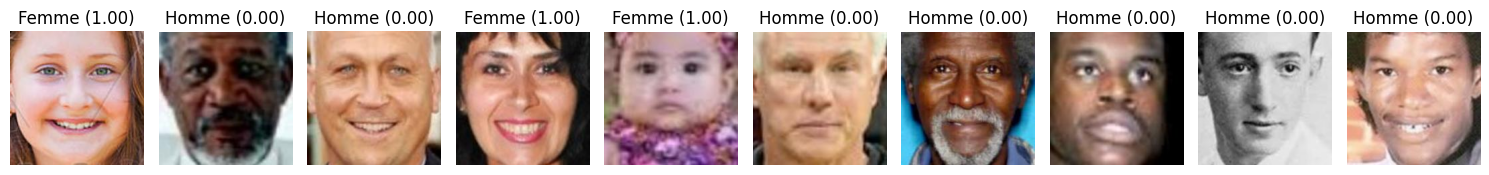

In [ ]:
class_names = ['Homme', 'Femme']

# Sélection de 5 images aléatoires dans le dossier
random_filenames = random.sample(os.listdir(data_dir), 10)

# Création d'une figure pour les 5 images
plt.figure(figsize=(15, 10))

for i, filename in enumerate(random_filenames):
    random_image_path = os.path.join(data_dir, filename)

    # Charger et prétraiter l'image
    img = load_img(random_image_path, target_size=(96, 96), color_mode="grayscale")  # Même taille que lors du training
    img_array = img_to_array(img)             # shape = (64, 64, 3)
    img_array = img_array / 255.0             # Normaliser (si fait lors du training)
    img_array = np.expand_dims(img_array, 0)  # shape = (1, 64, 64, 3)

    # Faire la prédiction
    prediction = model.predict(img_array)
    # Sortie = probabilité ; si > 0.5 => classe 1 (Femme), sinon 0 (Homme)
    predicted_class = 1 if prediction[0][0] > 0.5 else 0
    predicted_label = class_names[predicted_class]

    # Affichage dans la console
    print(f"Image '{filename}': prédiction = {predicted_label} "
          f"(Proba: {prediction[0][0]:.3f})")

    # Affichage dans la figure
    plt.subplot(1, 10, i + 1)
    plt.imshow(load_img(random_image_path))  # affiche l'image brute
    plt.title(f"{predicted_label} ({prediction[0][0]:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
data_dir = os.path.join(extracted_path, 'UTKFace')


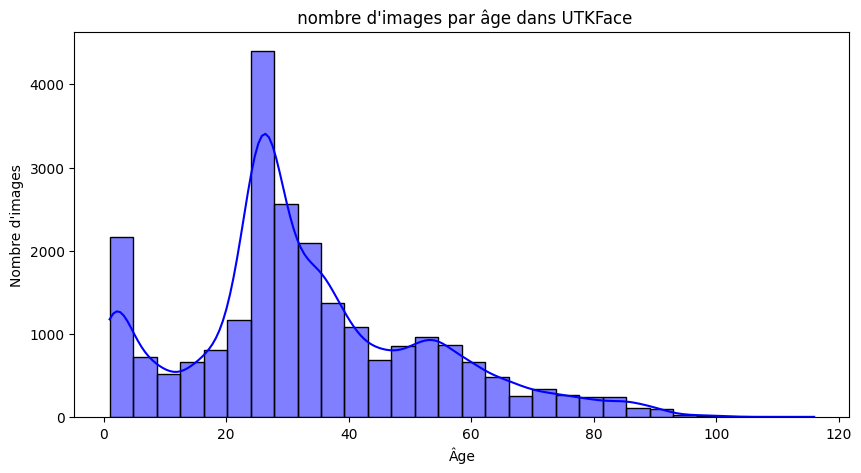

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Extraire l'âge depuis le nom de fichier
ages = []
for filename in os.listdir(data_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Vérifie si c'est une image
        try:
            age = int(filename.split('_')[0])  # L'âge est le premier élément du nom du fichier
            ages.append(age)
        except ValueError:
            pass  # Ignore les fichiers avec un nom incorrect

# Créer un DataFrame pour l'analyse
df = pd.DataFrame({'Âge': ages})

# Afficher la distribution avec seaborn
plt.figure(figsize=(10, 5))
sns.histplot(df, x="Âge", bins=30, kde=True, color="blue")
plt.xlabel("Âge")
plt.ylabel("Nombre d'images")
plt.title(" nombre d'images par âge dans UTKFace")
plt.show()


Model de donnée pour la detection de l'age

Entraînement d'un modèle CNN pour la prédiction de l'âge à partir d'images
Utilisation de la meme importation des données , pour pouvoir lancer le code de ce model sans avoir a lancer les cellules précedente pour eviter de perdre de faire crasher la ram avant meme d'atteindre cette cellule
Une MAE comprise entre 5-7 est raisonnable pour un model qui detecte l'age .


Shape des images : (23708, 96, 96, 1)
Shape des labels : (23708,)
Epoch 1/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 464.3094 - mae: 16.5070

593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 464.1169 - mae: 16.5032 - val_loss: 226.9885 - val_mae: 11.0014 - learning_rate: 0.0010
Epoch 2/50
591/593 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 230.4070 - mae: 11.5890

593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 230.3555 - mae: 11.5876 - val_loss: 158.8386 - val_mae: 9.4019 - learning_rate: 0.0010
Epoch 3/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 187.8356 - mae: 10.3948 - val_loss: 180.5221 - val_mae: 9.9870 - learning_rate: 0.0010
Epoch 4/50
588/593 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 158.3160 - mae: 9.4555

593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 158.2990 - mae: 9.4552 - val_loss: 122.1096 - val_mae: 8.4422 - learning_rate: 0.0010
Epoch 5/50
589/593 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 148.0524 - mae: 9.0972

593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 148.0034 - mae: 9.0957 - val_loss: 103.3699 - val_mae: 7.6420 - learning_rate: 0.0010
Epoch 6/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 127.7139 - mae: 8.5037

593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 127.7143 - mae: 8.5037 - val_loss: 95.6483 - val_mae: 7.3613 - learning_rate: 0.0010
Epoch 7/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 115.6355 - mae: 8.0148 - val_loss: 102.5376 - val_mae: 7.3754 - learning_rate: 0.0010
Epoch 8/50
592/593 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 116.5924 - mae: 8.0202

593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 116.5844 - mae: 8.0201 - val_loss: 95.4973 - val_mae: 7.1898 - learning_rate: 0.0010
Epoch 9/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 111.5488 - mae: 7.8738 - val_loss: 108.1313 - val_mae: 7.6120 - learning_rate: 0.0010
Epoch 10/50
588/593 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 103.6221 - mae: 7.5825

593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 103.6054 - mae: 7.5820 - val_loss: 87.6030 - val_mae: 6.7904 - learning_rate: 0.0010
Epoch 11/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 95.8899 - mae: 7.2973

593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 95.8915 - mae: 7.2974 - val_loss: 85.1220 - val_mae: 6.8849 - learning_rate: 0.0010
Epoch 12/50
592/593 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 94.5605 - mae: 7.2372

593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 94.5617 - mae: 7.2373 - val_loss: 83.4793 - val_mae: 6.7871 - learning_rate: 0.0010
Epoch 13/50
591/593 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 89.7201 - mae: 7.0194

593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 89.7187 - mae: 7.0195 - val_loss: 82.7320 - val_mae: 6.6301 - learning_rate: 0.0010
Epoch 14/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 83.8967 - mae: 6.8370 - val_loss: 83.2389 - val_mae: 6.8162 - learning_rate: 0.0010
Epoch 15/50
588/593 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 78.2447 - mae: 6.6220

593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 78.2635 - mae: 6.6225 - val_loss: 82.3248 - val_mae: 6.6511 - learning_rate: 0.0010
Epoch 16/50
588/593 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 79.9206 - mae: 6.6576

593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 79.9290 - mae: 6.6577 - val_loss: 81.0345 - val_mae: 6.6071 - learning_rate: 0.0010
Epoch 17/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 76.7714 - mae: 6.5375 - val_loss: 86.1413 - val_mae: 6.9309 - learning_rate: 0.0010
Epoch 18/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 71.0346 - mae: 6.2682 - val_loss: 84.0434 - val_mae: 6.6762 - learning_rate: 0.0010
Epoch 19/50
591/593 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 70.6213 - mae: 6.2662

593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 70.6236 - mae: 6.2663 - val_loss: 80.3614 - val_mae: 6.5500 - learning_rate: 0.0010
Epoch 20/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 68.2702 - mae: 6.2237 - val_loss: 85.5085 - val_mae: 6.8679 - learning_rate: 0.0010
Epoch 21/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 65.2275 - mae: 6.0168 - val_loss: 106.7293 - val_mae: 7.5386 - learning_rate: 0.0010
Epoch 22/50
592/593 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 62.6820 - mae: 5.9370
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 62.6852 - mae: 5.9371 - val_loss: 81.0187 - val_mae: 6.6924 - learning_rate: 0.0010
Epoch 23/50
592/593 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 58.0139 - mae: 5.7508

593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 58.0106 - mae: 5.7505 - val_loss: 79.8153 - val_mae: 6.4879 - learning_rate: 5.0000e-04
Epoch 24/50
589/593 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 53.8157 - mae: 5.4762

593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 53.8052 - mae: 5.4758 - val_loss: 78.9026 - val_mae: 6.4629 - learning_rate: 5.0000e-04
Epoch 25/50
591/593 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 52.5608 - mae: 5.4122

593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 52.5581 - mae: 5.4122 - val_loss: 78.7153 - val_mae: 6.4872 - learning_rate: 5.0000e-04
Epoch 26/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 50.2180 - mae: 5.3306 - val_loss: 81.9188 - val_mae: 6.5478 - learning_rate: 5.0000e-04
Epoch 27/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 50.0443 - mae: 5.3063 - val_loss: 79.6953 - val_mae: 6.5193 - learning_rate: 5.0000e-04
Epoch 28/50
588/593 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 49.5790 - mae: 5.3015
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 49.5838 - mae: 5.3015 - val_loss: 82.8347 - val_mae: 6.5940 - learning_rate: 5.0000e-04
Epoch 29/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 45.2792 - mae: 5.0715 - val_loss: 80.1347 - val_mae: 6.5712 - learning_rate: 2.5000e-04
Epoch 30/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 43.5812 - mae: 4.9943 - val_loss: 80.1581 - val

Erreur absolue moyenne (MAE) : 6.487203598022461 ans


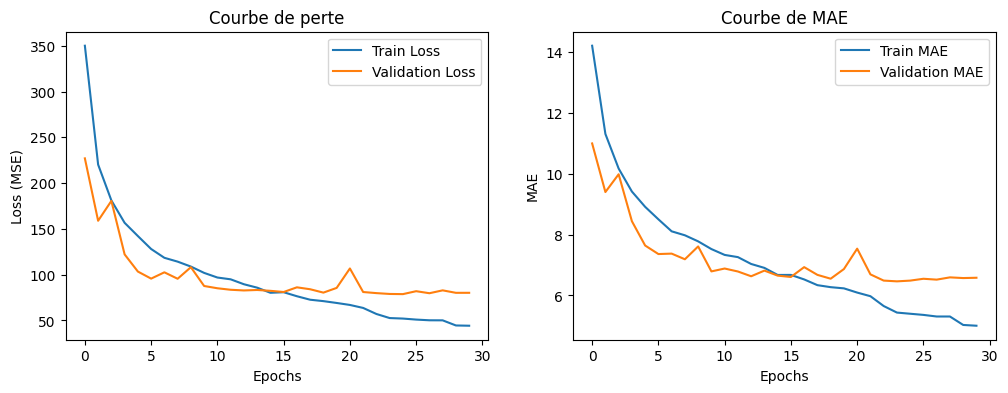

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt


zip_path = '/content/drive/MyDrive/Sae_BUT3_IA/archive.zip'
extracted_path = '/content/extracted'

# Extraction si non deja fait
if not os.path.exists(extracted_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

data_dir = os.path.join(extracted_path, 'UTKFace')

IMG_SIZE = (96, 96)
CHANNELS = 1  # Grayscale
X_data = []
y_data = []

#Chargement des images et extraction des labels
image_filenames = os.listdir(data_dir)

for image in image_filenames:
    if not image.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue  # ignore les fichiers qui ne sont pas des images

    # Chargement et redimensionnement en grayscale
    image_path = os.path.join(data_dir, image)
    img = load_img(image_path, target_size=IMG_SIZE, color_mode="grayscale")
    img_array = img_to_array(img) / 255.0  # Conversion en tableau et normalisation

    # Extraction de l'age depuis le nom du fichier
    try:
        age = int(image.split("_")[0])
        X_data.append(img_array)
        y_data.append(age)
    except ValueError:
        print(f"⚠ Erreur lors de l'extraction de l'âge pour {image}")

# Conversion en tableau numpy
X_data = np.array(X_data)
y_data = np.array(y_data)

# Reshape pour adapter au format TensorFlow (batch_size, height, width, channels)
X_data = X_data.reshape(-1, 96, 96, 1)

# Test d un print pour verifier les dimensions
print("Shape des images :", X_data.shape)  # Doit être (nombre_d'images, 96,96 1)
print("Shape des labels :", y_data.shape)

# Division en jeu d'entraînement et validation
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Définition du modèle CNN pour la régression de l'âge
modelAge = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='linear')  # Prédiction de l'âge
])
"""
model a tester
modelAge = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(96, 96, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='linear')
])
"""
# Compilation du modèle
modelAge.compile(optimizer='adam',  loss='mse',  metrics=['mae'])

# Ajout du early Stopping pour éviter le surapprentissage
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss', # Surveille la perte sur l’ensemble de validation.
    patience=5, # Attend 5 epochs sans amélioration avant d’arreter l'entrainement
    min_delta=0.01, # L’amélioration minimale requise de val_loss pour ne pas être comptée comme une stagnation (si l'amélioration est inférieure à 0.01, il considère que la perte ne s'améliore plus).
    restore_best_weights=True # Recharge les meilleurs poids trouvés avant l’arrêt pour éviter de garder les poids d'une epoch moins performante .
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Surveille la validation loss
    factor=0.5,          # Divise le learning rate par 2
    patience=3,          # Réduit le LR si la val_loss ne diminue pas après 2 epochs JAI CHANGE A 3 , remmetre a 2 si moin bien
    min_lr=1e-6,         # Valeur minimale du learning rate
    verbose=1            # Affiche un message lorsque le LR est réduit
)

checkpoint = ModelCheckpoint(
    "best_age_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

#  Entraînement du modèle
history = modelAge.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint,reduce_lr]
)

#  Évaluation du modèle
loss, mae = modelAge.evaluate(X_val, y_val)
print(f"Erreur absolue moyenne (MAE) : {mae} ans")

#  Sauvegarde du modèle
modelAge.save("age_prediction_model.h5")

# Affichage des courbes de perte
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Courbe de perte
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.title('Courbe de perte')

    # Courbe d'erreur absolue moyenne (MAE)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.title('Courbe de MAE')

    plt.show()

plot_training_history(history)


Model de detection d'age mais cette fois si par tranche d'age exemple [0-10] , [10-20] , etc

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Définition des tranches d'âge (avec 100-120 ans)
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120]
age_labels = [f"{age_bins[i]}-{age_bins[i+1]}" for i in range(len(age_bins)-1)]

#  Chargement des images et extraction des labels
IMG_SIZE = (96,96)
X_data, y_data = [], []
data_dir = '/content/extracted/UTKFace'  # Met ton chemin ici

for image in os.listdir(data_dir):
    if image.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:
            age = int(image.split("_")[0])  # Extraire l'âge

            if age > 120 or age < 0:  # Éviter les âges anormaux
                continue

            img = load_img(os.path.join(data_dir, image), target_size=IMG_SIZE, color_mode="grayscale")
            X_data.append(img_to_array(img) / 255.0)

            # Convertir âge en catégorie (One-Hot)
            age_category = np.digitize([age], bins=age_bins) - 1
            y_data.append(age_category[0])

        except ValueError:
            continue

X_data, y_data = np.array(X_data).reshape(-1, 96, 96, 1), np.array(y_data)

#  Transformation des labels en One-Hot Encoding
y_data = to_categorical(y_data, num_classes=len(age_bins)-1)

#  Division en train/test
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

#  Augmentation des données
datagen = ImageDataGenerator(
    rotation_range=20,     # Rotation aléatoire jusqu'à ±20°
    width_shift_range=0.2, # Décalage horizontal
    height_shift_range=0.2, # Décalage vertical
    zoom_range=0.2,        # Zoom aléatoire
    horizontal_flip=True   # Flip horizontal
)
datagen.fit(X_train)

# Définition du modèle CNN amélioré
model = Sequential([
    Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(96, 96, 1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Plus de régularisation
    Dense(len(age_bins)-1, activation='softmax')  # Classification
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#  Callbacks : EarlyStopping et ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

# Entraînement du modèle avec Data Augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=50, callbacks=callbacks)

#  Évaluation du modèle
loss, acc = model.evaluate(X_val, y_val)
print(f"📊 Accuracy : {acc:.2%}")

#  Prédictions et Matrice de Confusion
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(11, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=age_labels, yticklabels=age_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion des classes d'âge")
plt.show()

# Rapport de classification
print(classification_report(y_true, y_pred, target_names=age_labels))

# Courbes d'apprentissage
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Courbe de perte')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Courbe d’accuracy')
    plt.show()

plot_training_history(history)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - loss: 475.9735 - mae: 16.7685

593/593 ━━━━━━━━━━━━━━━━━━━━ 363s 608ms/step - loss: 475.8046 - mae: 16.7653 - val_loss: 263.3907 - val_mae: 13.4727 - learning_rate: 0.0010
Epoch 2/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - loss: 239.1361 - mae: 11.8273

593/593 ━━━━━━━━━━━━━━━━━━━━ 362s 575ms/step - loss: 239.1113 - mae: 11.8266 - val_loss: 153.2205 - val_mae: 9.3774 - learning_rate: 0.0010
Epoch 3/50
277/593 ━━━━━━━━━━━━━━━━━━━━ 2:49 537ms/step - loss: 186.0429 - mae: 10.4101

KeyboardInterrupt: 

Test du model de detection d'age avec aleatoirement 20 images prises du datasets .

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step


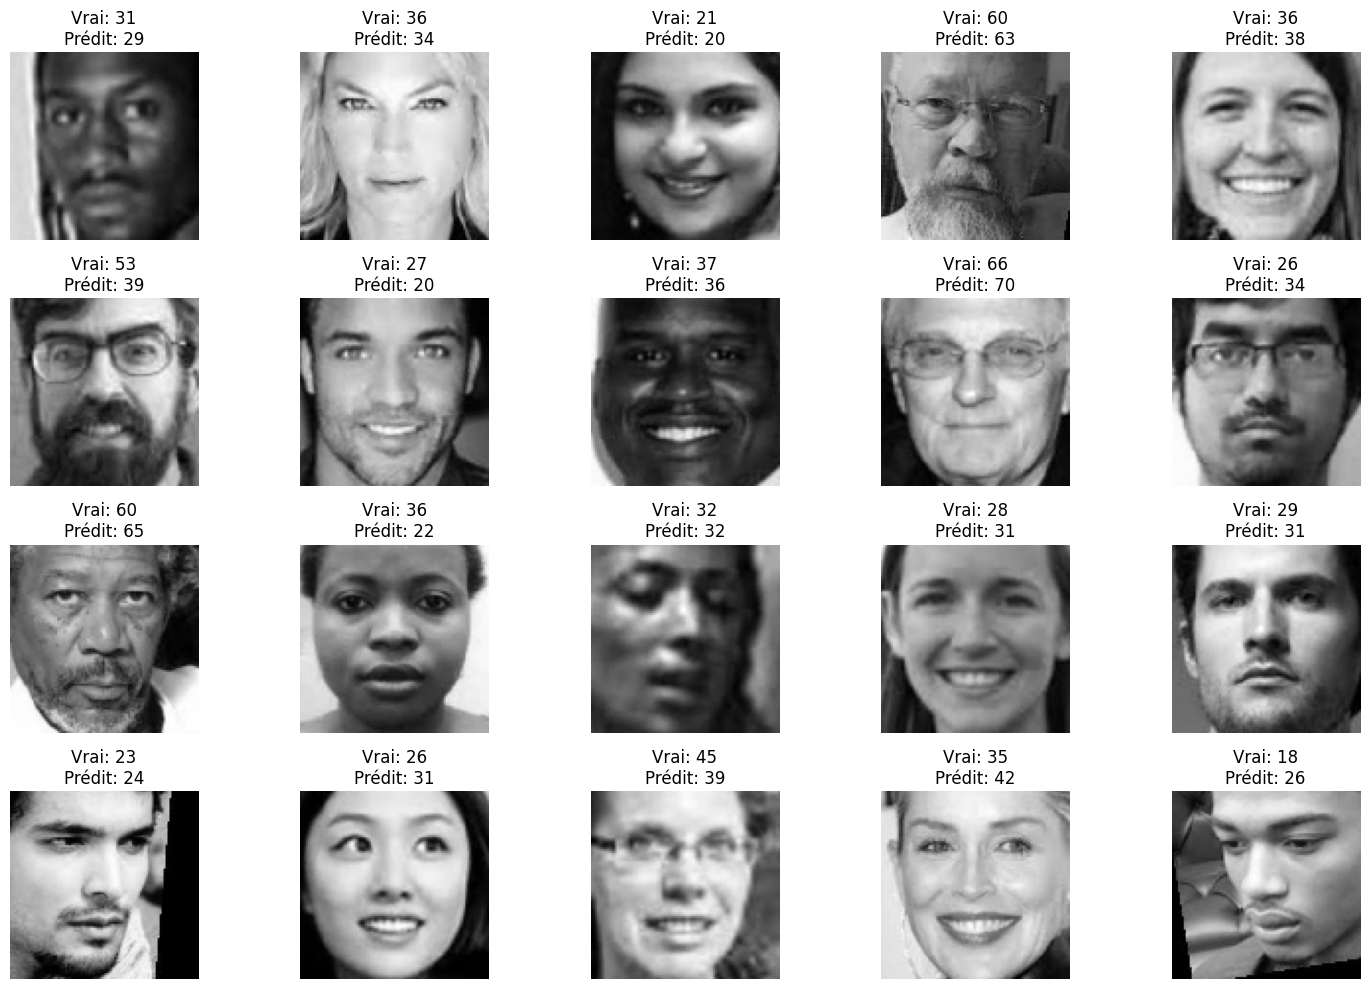

In [ ]:
import random
import matplotlib.pyplot as plt

#  Sélectionner 20 images aléatoires du jeu de validation
num_samples = 20
indices = random.sample(range(len(X_val)), num_samples)
X_test_samples = X_val[indices]
y_test_samples = y_val[indices]

#  Faire les prédictions
predicted_ages = modelAge.predict(X_test_samples).flatten()  # Convertir en tableau 1D

#  Afficher les résultats
plt.figure(figsize=(15, 10))

for i in range(num_samples):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test_samples[i].reshape(96, 96), cmap='gray')  # Affichage en grayscale
    plt.axis('off')
    plt.title(f"Vrai: {y_test_samples[i]}\nPrédit: {int(predicted_ages[i])}")

plt.tight_layout()
plt.show()


Test du model avec une image externe au dataset , avec un lien necessaire .  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


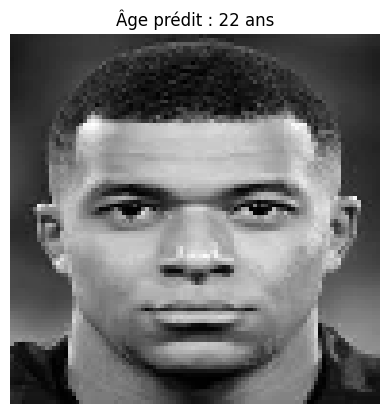

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Chemin de l'image extérieure
image_path = "/content/drive/MyDrive/téléchargement2.jpeg"  # Mets le chemin de ton image

#  Charger et prétraiter l'image
IMG_SIZE = (96, 96)  # Taille utilisée pendant l'entraînement

img = load_img(image_path, target_size=IMG_SIZE, color_mode="grayscale")  # Grayscale
img_array = img_to_array(img) / 255.0  # Normalisation (0-1)
img_array = np.expand_dims(img_array, axis=0)  # Ajouter batch_size (1, 64, 64, 1)

#  Charger le modèle entraîné
model = tf.keras.models.load_model("age_prediction_model.h5", custom_objects={'mse': tf.keras.losses.MeanSquaredError()}) # Add this line

# Faire la prédiction
predicted_age = model.predict(img_array)[0][0]  # Récupérer la prédiction

#  Afficher l'image et l'âge prédit
plt.imshow(img_array[0].reshape(96 , 96), cmap="gray")
plt.axis("off")
plt.title(f"Âge prédit : {int(predicted_age)} ans")
plt.show()


Model de detection d'age et de genre reunis , haute performance plus compliqué a atteindre .

Shape des images : (23708, 96, 96, 1)
Shape des labels d'âge : (23708,)
Shape des labels de genre : (23708,)
Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - age_output_loss: 14.8467 - age_output_mae: 14.8467 - gender_output_accuracy: 0.6762 - gender_output_loss: 1.6104 - loss: 16.4571

297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - age_output_loss: 14.8386 - age_output_mae: 14.8386 - gender_output_accuracy: 0.6763 - gender_output_loss: 1.6086 - loss: 16.4472 - val_age_output_loss: 12.6480 - val_age_output_mae: 12.7219 - val_gender_output_accuracy: 0.5261 - val_gender_output_loss: 1.2782 - val_loss: 13.9902 - learning_rate: 0.0010
Epoch 2/50
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - age_output_loss: 9.9930 - age_output_mae: 9.9930 - gender_output_accuracy: 0.7511 - gender_output_loss: 0.5400 - loss: 10.5330

297/297 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - age_output_loss: 9.9895 - age_output_mae: 9.9894 - gender_output_accuracy: 0.7512 - gender_output_loss: 0.5396 - loss: 10.5291 - val_age_output_loss: 11.2088 - val_age_output_mae: 11.2134 - val_gender_output_accuracy: 0.8224 - val_gender_output_loss: 0.4000 - val_loss: 11.6142 - learning_rate: 0.0010
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - age_output_loss: 8.9197 - age_output_mae: 8.9197 - gender_output_accuracy: 0.7751 - gender_output_loss: 0.4740 - loss: 9.3937 - val_age_output_loss: 11.4836 - val_age_output_mae: 11.5157 - val_gender_output_accuracy: 0.8231 - val_gender_output_loss: 0.3965 - val_loss: 11.9150 - learning_rate: 0.0010
Epoch 4/50
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - age_output_loss: 8.3711 - age_output_mae: 8.3711 - gender_output_accuracy: 0.8023 - gender_output_loss: 0.4320 - loss: 8.8031

297/297 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - age_output_loss: 8.3707 - age_output_mae: 8.3707 - gender_output_accuracy: 0.8023 - gender_output_loss: 0.4320 - loss: 8.8027 - val_age_output_loss: 9.9188 - val_age_output_mae: 9.9382 - val_gender_output_accuracy: 0.8391 - val_gender_output_loss: 0.3452 - val_loss: 10.2854 - learning_rate: 0.0010
Epoch 5/50
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - age_output_loss: 8.0566 - age_output_mae: 8.0566 - gender_output_accuracy: 0.8120 - gender_output_loss: 0.4054 - loss: 8.4620

297/297 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - age_output_loss: 8.0567 - age_output_mae: 8.0567 - gender_output_accuracy: 0.8120 - gender_output_loss: 0.4053 - loss: 8.4620 - val_age_output_loss: 6.9776 - val_age_output_mae: 6.9724 - val_gender_output_accuracy: 0.8678 - val_gender_output_loss: 0.2858 - val_loss: 7.2597 - learning_rate: 0.0010
Epoch 6/50
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - age_output_loss: 7.5889 - age_output_mae: 7.5889 - gender_output_accuracy: 0.8203 - gender_output_loss: 0.3879 - loss: 7.9769

297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - age_output_loss: 7.5895 - age_output_mae: 7.5895 - gender_output_accuracy: 0.8203 - gender_output_loss: 0.3879 - loss: 7.9774 - val_age_output_loss: 6.9805 - val_age_output_mae: 6.9525 - val_gender_output_accuracy: 0.8756 - val_gender_output_loss: 0.2765 - val_loss: 7.2310 - learning_rate: 0.0010
Epoch 7/50
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - age_output_loss: 7.6210 - age_output_mae: 7.6210 - gender_output_accuracy: 0.8231 - gender_output_loss: 0.3836 - loss: 8.0046

297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - age_output_loss: 7.6207 - age_output_mae: 7.6207 - gender_output_accuracy: 0.8231 - gender_output_loss: 0.3836 - loss: 8.0043 - val_age_output_loss: 6.7933 - val_age_output_mae: 6.7906 - val_gender_output_accuracy: 0.8758 - val_gender_output_loss: 0.2693 - val_loss: 7.0612 - learning_rate: 0.0010
Epoch 8/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - age_output_loss: 7.3299 - age_output_mae: 7.3299 - gender_output_accuracy: 0.8319 - gender_output_loss: 0.3543 - loss: 7.6842 - val_age_output_loss: 8.0259 - val_age_output_mae: 8.0092 - val_gender_output_accuracy: 0.8781 - val_gender_output_loss: 0.2665 - val_loss: 8.2776 - learning_rate: 0.0010
Epoch 9/50
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - age_output_loss: 6.9832 - age_output_mae: 6.9832 - gender_output_accuracy: 0.8362 - gender_output_loss: 0.3527 - loss: 7.3359

297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - age_output_loss: 6.9839 - age_output_mae: 6.9839 - gender_output_accuracy: 0.8362 - gender_output_loss: 0.3527 - loss: 7.3366 - val_age_output_loss: 6.6060 - val_age_output_mae: 6.5752 - val_gender_output_accuracy: 0.8680 - val_gender_output_loss: 0.2864 - val_loss: 6.8627 - learning_rate: 0.0010
Epoch 10/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - age_output_loss: 6.7857 - age_output_mae: 6.7857 - gender_output_accuracy: 0.8401 - gender_output_loss: 0.3455 - loss: 7.1313 - val_age_output_loss: 7.7342 - val_age_output_mae: 7.6721 - val_gender_output_accuracy: 0.8895 - val_gender_output_loss: 0.2467 - val_loss: 7.9190 - learning_rate: 0.0010
Epoch 11/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - age_output_loss: 6.6806 - age_output_mae: 6.6807 - gender_output_accuracy: 0.8463 - gender_output_loss: 0.3379 - loss: 7.0186 - val_age_output_loss: 7.1266 - val_age_output_mae: 7.1408 - val_gender_output_accuracy: 0.8790 - val_gender_output_los

297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - age_output_loss: 6.3377 - age_output_mae: 6.3377 - gender_output_accuracy: 0.8637 - gender_output_loss: 0.2942 - loss: 6.6319 - val_age_output_loss: 6.1691 - val_age_output_mae: 6.1530 - val_gender_output_accuracy: 0.8903 - val_gender_output_loss: 0.2387 - val_loss: 6.3932 - learning_rate: 5.0000e-04
Epoch 13/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - age_output_loss: 5.9432 - age_output_mae: 5.9432 - gender_output_accuracy: 0.8708 - gender_output_loss: 0.2896 - loss: 6.2329 - val_age_output_loss: 6.2452 - val_age_output_mae: 6.2101 - val_gender_output_accuracy: 0.8889 - val_gender_output_loss: 0.2361 - val_loss: 6.4470 - learning_rate: 5.0000e-04
Epoch 14/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - age_output_loss: 5.9308 - age_output_mae: 5.9308 - gender_output_accuracy: 0.8657 - gender_output_loss: 0.3039 - loss: 6.2346 - val_age_output_loss: 6.5654 - val_age_output_mae: 6.5303 - val_gender_output_accuracy: 0.8880 - val_gender_out

297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - age_output_loss: 5.7629 - age_output_mae: 5.7629 - gender_output_accuracy: 0.8749 - gender_output_loss: 0.2734 - loss: 6.0363 - val_age_output_loss: 6.1825 - val_age_output_mae: 6.1520 - val_gender_output_accuracy: 0.8884 - val_gender_output_loss: 0.2313 - val_loss: 6.3842 - learning_rate: 2.5000e-04
Epoch 16/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - age_output_loss: 5.5243 - age_output_mae: 5.5243 - gender_output_accuracy: 0.8724 - gender_output_loss: 0.2829 - loss: 5.8073 - val_age_output_loss: 6.8932 - val_age_output_mae: 6.8734 - val_gender_output_accuracy: 0.8802 - val_gender_output_loss: 0.2446 - val_loss: 7.1179 - learning_rate: 2.5000e-04
Epoch 17/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - age_output_loss: 5.4849 - age_output_mae: 5.4848 - gender_output_accuracy: 0.8735 - gender_output_loss: 0.2761 - loss: 5.7610 - val_age_output_loss: 6.2411 - val_age_output_mae: 6.2054 - val_gender_output_accuracy: 0.8903 - val_gender_out

MAE (Age) : 6.152953624725342 ans
Accuracy (Genre) : 89.03%


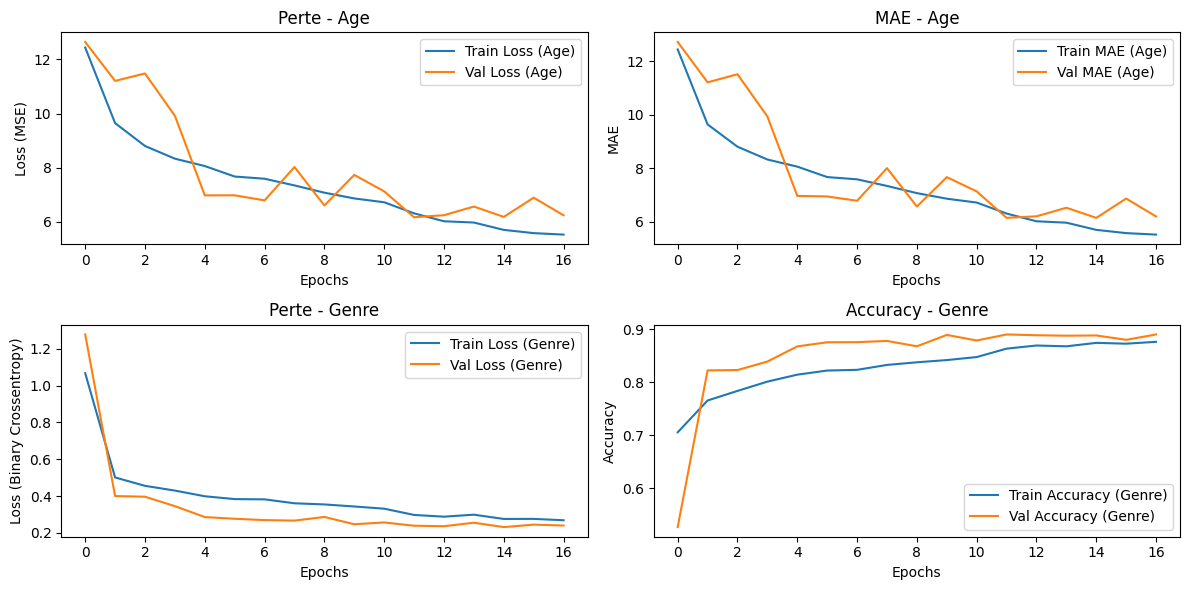

In [ ]:
# model age et genre

import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
import matplotlib.pyplot as plt

#  Chemins vers l'archive ZIP et extraction
zip_path = '/content/drive/MyDrive/Sae_BUT3_IA/archive.zip'
extracted_path = '/content/extracted'

if not os.path.exists(extracted_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

data_dir = os.path.join(extracted_path, 'UTKFace')

# Paramètres
IMG_SIZE = (96, 96)
CHANNELS = 1  # Grayscale
X_data = []
age_labels = []
gender_labels = []

#  Chargement des images et extraction des labels
image_filenames = os.listdir(data_dir)

for image in image_filenames:
    if not image.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    image_path = os.path.join(data_dir, image)
    img = load_img(image_path, target_size=IMG_SIZE, color_mode="grayscale")
    img_array = img_to_array(img) / 255.0

    try:
        # Extraction de l'âge et du genre
        age = int(image.split("_")[0])
        gender = int(image.split("_")[1])  # 0 = Homme, 1 = Femme

        X_data.append(img_array)
        age_labels.append(age)
        gender_labels.append(gender)
    except ValueError:
        print(f"⚠ Erreur d'extraction pour {image}")

# Conversion en numpy
X_data = np.array(X_data)
age_labels = np.array(age_labels)
gender_labels = np.array(gender_labels)

X_data = X_data.reshape(-1, 96, 96, 1)

print("Shape des images :", X_data.shape)
print("Shape des labels d'âge :", age_labels.shape)
print("Shape des labels de genre :", gender_labels.shape)

#  Division en jeu d'entraînement et validation
X_train, X_val, y_train_age, y_val_age, y_train_gender, y_val_gender = train_test_split(
    X_data, age_labels, gender_labels, test_size=0.2, random_state=42
)

#  Définition du modèle CNN multitâche
input_layer = Input(shape=(96, 96, 1))


x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2,2))(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)




# Sortie âge (régression)
age_output = Dense(1, activation='linear', name='age_output')(x)

# Sortie genre (classification binaire)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)

# Création du modèle
modelAgeGenre = Model(inputs=input_layer, outputs=[age_output, gender_output])

# Compilation
modelAgeGenre.compile(
    optimizer='adam',
    loss={'age_output': 'mae', 'gender_output': 'binary_crossentropy'},
    metrics={'age_output': 'mae', 'gender_output': 'accuracy'}
)


#  Early Stopping et Checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(Modification de l’IMG_SIZE
    monitor='val_loss',
    patience=5,
    min_delta=0.01,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_age_genre_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


# Entraînement du modèle
history = modelAgeGenre.fit(
    X_train,
    {'age_output': y_train_age, 'gender_output': y_train_gender},
    batch_size=64,
    epochs=50,
    validation_data=(
        X_val,
        {'age_output': y_val_age, 'gender_output': y_val_gender}
    ),
    callbacks=[early_stopping, checkpoint,lr_scheduler]
)

#  Évaluation du modèle
loss, age_loss, gender_loss, age_mae, gender_acc = modelAgeGenre.evaluate(
    X_val,
    {'age_output': y_val_age, 'gender_output': y_val_gender}
)

print(f"MAE (Age) : {age_mae} ans")
print(f"Accuracy (Genre) : {gender_acc*100:.2f}%")

#  Sauvegarde du modèle
modelAgeGenre.save("age_genre_prediction_model.h5")

#  Courbes de performance
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Courbe de perte pour l'âge
    plt.subplot(2, 2, 1)
    plt.plot(history.history['age_output_loss'], label='Train Loss (Age)')
    plt.plot(history.history['val_age_output_loss'], label='Val Loss (Age)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.title('Perte - Age')

    # Courbe de MAE pour l'âge
    plt.subplot(2, 2, 2)
    plt.plot(history.history['age_output_mae'], label='Train MAE (Age)')
    plt.plot(history.history['val_age_output_mae'], label='Val MAE (Age)')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.title('MAE - Age')

    # Courbe de perte pour le genre
    plt.subplot(2, 2, 3)
    plt.plot(history.history['gender_output_loss'], label='Train Loss (Genre)')
    plt.plot(history.history['val_gender_output_loss'], label='Val Loss (Genre)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Binary Crossentropy)')
    plt.legend()
    plt.title('Perte - Genre')

    # Courbe d'accuracy pour le genre
    plt.subplot(2, 2, 4)
    plt.plot(history.history['gender_output_accuracy'], label='Train Accuracy (Genre)')
    plt.plot(history.history['val_gender_output_accuracy'], label='Val Accuracy (Genre)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy - Genre')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


Test du model de Genre et d’Age pour évaluer les differentes predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


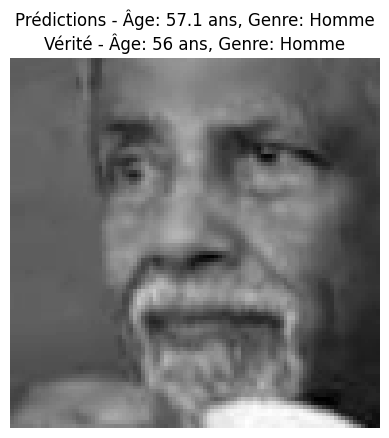

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


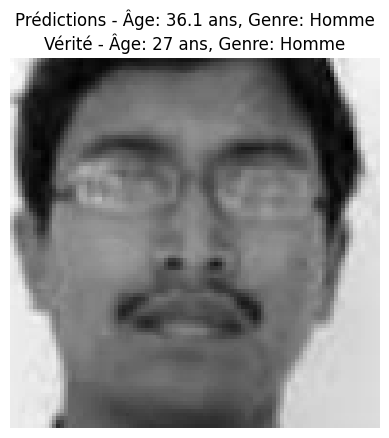

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


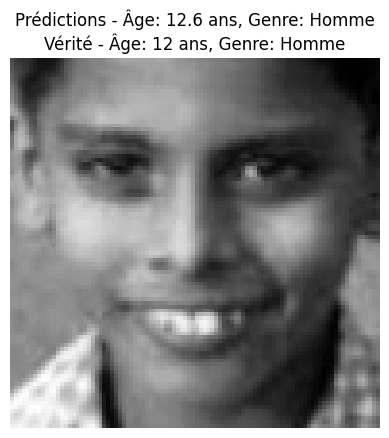

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


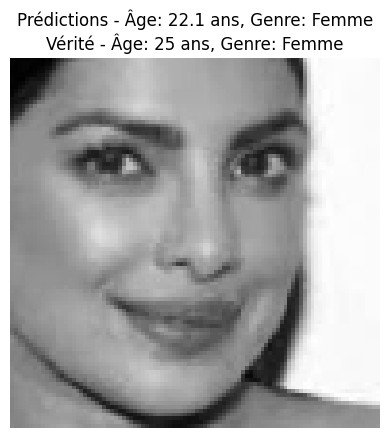

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


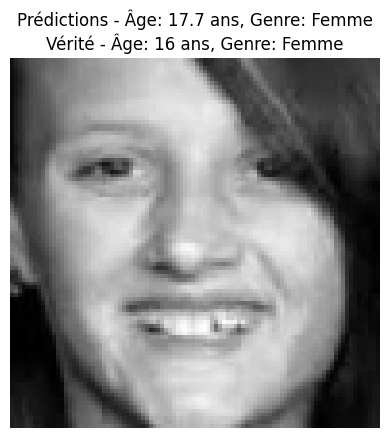

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import random
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

# Charger le modèle avec custom_objects
model = load_model("age_genre_prediction_model.h5", custom_objects={
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()  # Ajout correct de MAE
})


# Charger les chemins des images
data_dir = '/content/extracted/UTKFace'
image_filenames = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Sélectionner 5 images aléatoirement
random_images = random.sample(image_filenames, 5)

# Fonction pour prédire l'âge et le genre
def predict_age_genre(image_path):
    # Charger et préparer l'image
    img = load_img(image_path, target_size=(96, 96), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour la batch

    # Prédiction
    predicted_age, predicted_gender = model.predict(img_array)

    # Prédiction du genre
    gender = "Femme" if predicted_gender[0] >= 0.5 else "Homme"

    # Return the age as a float by extracting the value from the array
    return predicted_age[0][0], gender  # Access element using [0][0]

# Afficher les résultats pour les 5 images choisies aléatoirement
for i, image_filename in enumerate(random_images):
    image_path = os.path.join(data_dir, image_filename)

    # Extraire les labels réels à partir du nom du fichier
    try:
        age_real = int(image_filename.split("_")[0])
        gender_real = "Femme" if int(image_filename.split("_")[1]) == 1 else "Homme"
    except ValueError:
        continue  # Si le nom de fichier ne suit pas le format attendu

    # Prédiction de l'âge et du genre
    age_pred, gender_pred = predict_age_genre(image_path)

    # Affichage de l'image et des prédictions
    display_img = load_img(image_path, target_size=(96, 96), color_mode='grayscale')
    display_img_array = img_to_array(display_img)

    # Affichage de l'image avec les prédictions et la vérité
    plt.imshow(display_img_array.reshape(96, 96), cmap="gray")
    plt.axis("off")  # Enlever les axes

    # Afficher les prédictions et les vérités
    plt.title(f"Prédictions - Âge: {age_pred:.1f} ans, Genre: {gender_pred}\nVérité - Âge: {age_real} ans, Genre: {gender_real}")
    plt.show()


Entrainement du Model Pregenere par MobileNetV2


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#  Chemin vers les images
data_dir = "/content/extracted/UTKFace"

#  Paramètres
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

#  Fonction pour charger et prétraiter les images en streaming
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE) / 255.0  # Normalisation
    return image, label

#  Récupération des chemins et des labels
image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]
labels = [(int(img.split("_")[0]), int(img.split("_")[1])) for img in os.listdir(data_dir)]  # (âge, genre)

#  Création du dataset optimisé
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(load_image).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#  Séparation train/validation
train_size = int(0.8 * len(image_paths))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

#  Charger MobileNetV2 (pré-entraîné sur ImageNet)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Geler les poids

#  Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

#  Sortie pour l'âge (régression)
age_output = Dense(1, activation="linear", name="age_output")(x)

#  Sortie pour le genre (classification binaire)
gender_branch = Dense(256, activation="relu")(x)
gender_branch = Dropout(0.5)(gender_branch)
gender_output = Dense(1, activation="sigmoid", name="gender_output")(gender_branch)

# Créer le modèle
model = Model(inputs=base_model.input, outputs=[age_output, gender_output])

#  Compilation avec un learning rate bas
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss={"age_output": "mse", "gender_output": "binary_crossentropy"},
    metrics={"age_output": "mae", "gender_output": "accuracy"}
)

# Callbacks (optimisation automatique)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Entraînement avec un chargement optimisé des images
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

# Sauvegarde du modèle
model.save("age_gender_prediction_model_transfer.h5")

#  Affichage des courbes d'entraînement
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.plot(history.history["age_output_loss"], label="Train Loss (Age)")
    plt.plot(history.history["val_age_output_loss"], label="Val Loss (Age)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.title("Perte - Age")

    plt.subplot(2, 2, 2)
    plt.plot(history.history["age_output_mae"], label="Train MAE (Age)")
    plt.plot(history.history["val_age_output_mae"], label="Val MAE (Age)")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.title("MAE - Age")

    plt.subplot(2, 2, 3)
    plt.plot(history.history["gender_output_loss"], label="Train Loss (Genre)")
    plt.plot(history.history["val_gender_output_loss"], label="Val Loss (Genre)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Binary Crossentropy)")
    plt.legend()
    plt.title("Perte - Genre")

    plt.subplot(2, 2, 4)
    plt.plot(history.history["gender_output_accuracy"], label="Train Accuracy (Genre)")
    plt.plot(history.history["val_gender_output_accuracy"], label="Val Accuracy (Genre)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy - Genre")

    plt.tight_layout()
    plt.show()

plot_training_history(history)


Shape des images : (23708, 96, 96, 3)
Shape des labels d'âge : (23708,)
Shape des labels de genre : (23708,)
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
!pip install streamlit

!npm install -g localtunnel


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙
added 22 packages in 3s
⠙
⠙3 packages are looking for funding
⠙  run `npm fund` for details
⠙

In [ ]:
import tensorflow as tf

# Vérifie la version de TensorFlow
print("TensorFlow version :", tf.__version__)

# Charge le modèle existant
model = tf.keras.models.load_model("best_age_model.h5", compile=False)

# Vérifie la structure du modèle
model.summary()


TensorFlow version : 2.18.0


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 94, 94, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,369,985 (12.86 MB)

 Trainable params: 3,369,985 (12.86 MB)

 Non-trainable params: 0 (0.00 B)